# Symbolic regression

## 4.1 Importing libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from gplearn.genetic import SymbolicRegressor
import sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sympy import *
from sklearn.utils.random import check_random_state
import graphviz
import time

## 4.2 Initial dataset and data analysis

In [2]:
nsample = 1000
sig = 0.2

In [3]:
def Hz(z):
    H0 = 67.3
    Omega_m = 0.3115
    Omega_r = 2.473*10**(-5)
    Omega_de = 0.685
    Omega_k = 1. - Omega_m - Omega_r - Omega_de
    return H0*np.sqrt(Omega_k*(1 + z)**2 + Omega_m*(1 + z)**3 + Omega_r*(1 + z)**4 + Omega_de)

In [4]:
rng = check_random_state(0)
z = rng.uniform(0, 10, nsample)
H = Hz(z) + sig*np.random.normal(size=nsample)

In [5]:
data = np.array([z, H]).T
columns = ['z', 'H (z)']
df = pd.DataFrame(data = data, columns = columns)
df.head()

,z,H (z)
0,5.488135,623.693222
1,7.151894,876.495357
2,6.027634,702.487200
3,5.448832,618.422791
4,4.236548,454.333442


Text(0.5, 0, '$z$')

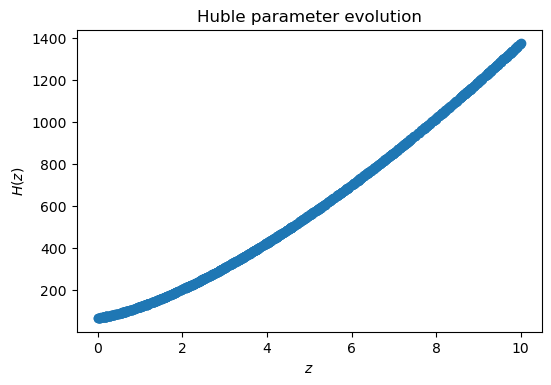

In [47]:
plt.figure(dpi = 100)
plt.title('Huble parameter evolution')
plt.scatter(df['z'], df['H (z)'])
plt.ylabel(r'$H (z)$')
plt.xlabel(r'$z$')

# 4.3 ML getting data

In [7]:
X = df[['z']]
y = df['H (z)']
y_true = y
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.30, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((700, 1), (300, 1), (700,), (300,))

## 4.4 GPlearn Implementation

### 4.4.1 First test

In [48]:
# Choosing just some functions
function_set = ['add', 'sub', 'mul']

In [9]:
est_gp = SymbolicRegressor(population_size=5000,function_set=function_set,
                           generations=20, stopping_criteria=0.01,
                           p_crossover=0.7, p_subtree_mutation=0.1,
                           p_hoist_mutation=0.05, p_point_mutation=0.1,
                           max_samples=0.9, verbose=1,
                           parsimony_coefficient=0.01, random_state=0)

In [49]:
# Fit 

t0 = time.time()
est_gp.fit(X_train, y_train)
print('Time to fit:', time.time() - t0, 'seconds')

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    25.88      1.57098e+18       31         0.292091         0.525616     57.80s
   1     4.24          2225.44       13         0.197367         0.248983     40.72s
   2     3.81      1.77029e+10       13         0.183544         0.373388     39.71s
   3     3.48      1.43137e+08       13         0.186416          0.34754     37.18s
   4     5.05          79497.2       13         0.175306         0.447528     35.01s
   5     9.10           648089       25         0.181902         0.301818     35.22s
   6    11.11          16325.6       11           0.1766         0.286404     34.07s
   7     9.68           787577        9         0.170067         0.299658     29.33s
   8     8.89          9596.91       11         0.175895         0.135876  

In [50]:
# Prediction 

t0 = time.time()
y_gp1 = est_gp.predict(X_test)
print('Time to predict:', time.time() - t0, 'seconds')

Time to predict: 0.0 seconds


In [51]:
# Score 

score_gp1 = est_gp.score(X_test, y_test)
print('R2:', score_gp1)

R2: 0.6000000000000001


#### 4.4.1.1 Visualizing the symbolic function

In [52]:
# Equation

converter = {
    'add': lambda x, y : x + y,
    'sub': lambda x, y : x - y,
    'mul': lambda x, y : x*y,
    'div': lambda x, y : x/y,
    'sqrt': lambda x : x**0.5,
    'log': lambda x : log(x),
    'abs': lambda x : abs(x),
    'neg': lambda x : -x,
    'inv': lambda x : 1/x,
    'max': lambda x, y : max(x, y),
    'min': lambda x, y : min(x, y),
    'sin': lambda x : sin(x),
    'cos': lambda x : cos(x),
    'pow': lambda x, y : x**y,
}

In [14]:
next_e = sympify(str(est_gp._program), locals=converter)
next_e

(3.928432*X0 + 6.808)*(-X0**2 + X0*(0.806*X0 + 1.681) + 2.806*X0 + 3.621)

In [15]:
# Score
y_gp = est_gp.predict(X_test)
score_gp1 = est_gp.score(X_test, y_test)
score_gp1

0.9968266118230628

Text(0.5, 0, 'z')

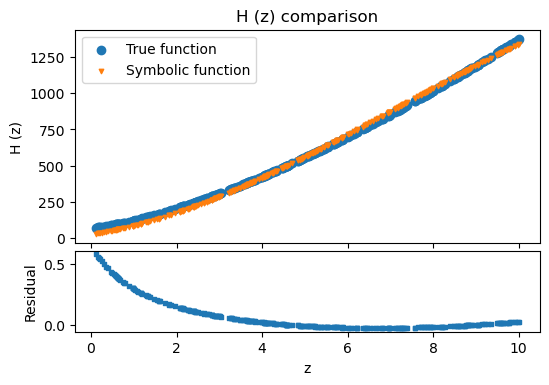

In [16]:
# c. Plot
fig = plt.figure(constrained_layout=False, dpi=100)
gs = fig.add_gridspec(nrows=7, ncols=1)
f_ax1 = fig.add_subplot(gs[0:5,0])
plt.title('H (z) comparison')
plt.scatter(X_test, y_test, label = 'True function')
plt.scatter(X_test, y_gp1, marker = 'v', s = 10, label = 'Symbolic function')
plt.legend()
plt.ylabel('H (z)')
f_ax2 = fig.add_subplot(gs[5:7, 0])
plt.scatter(X_test, 1. - y_gp1/y_test, marker = 's', s = 10)
plt.ylabel('Residual')
plt.xlabel('z')

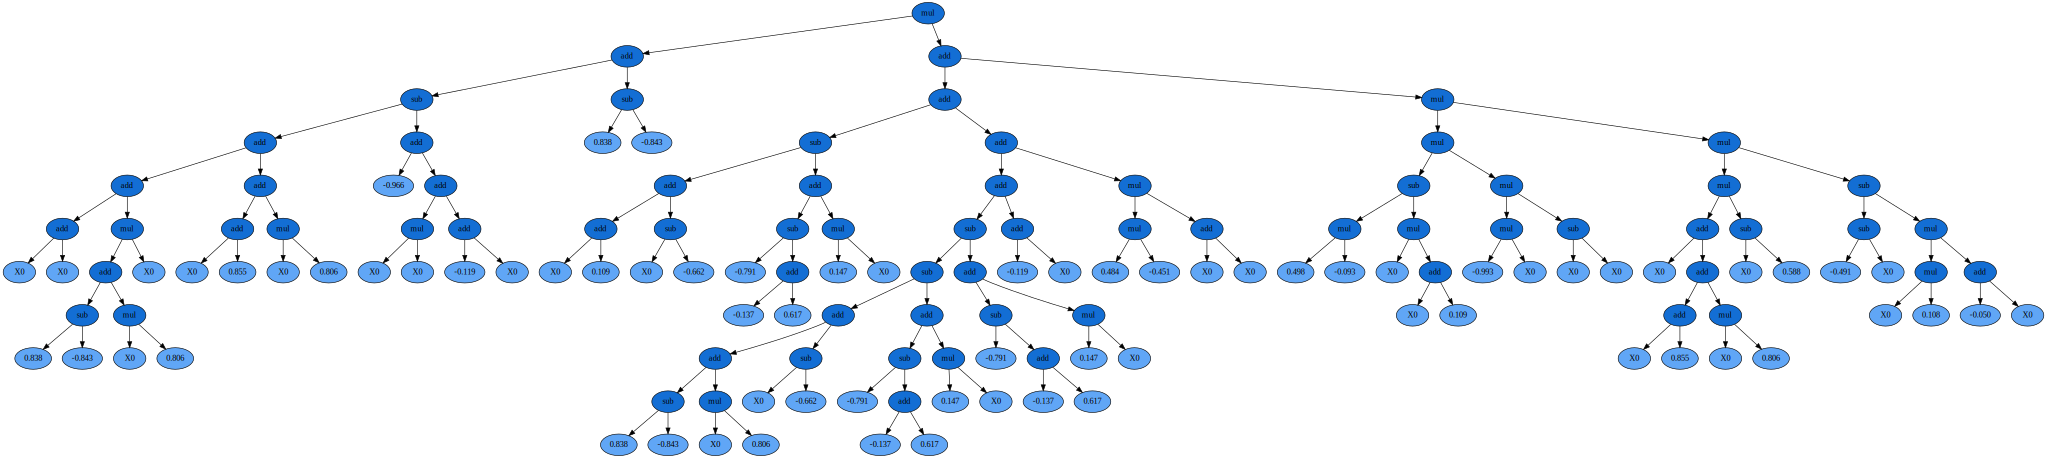

In [17]:
# Tree 
dot_data = est_gp._program.export_graphviz()
graph = graphviz.Source(dot_data)
graph.render('images/ex1', format='png', cleanup=True)
graph

#### 4.4.2 Second test

In [18]:
# Not imposing any function
est_gp = SymbolicRegressor(population_size=5000,
                           generations=20, stopping_criteria=0.01,
                           p_crossover=0.7, p_subtree_mutation=0.1,
                           p_hoist_mutation=0.05, p_point_mutation=0.1,
                           max_samples=0.9, verbose=1,
                           parsimony_coefficient=0.01, random_state=0)

In [19]:
# Fit
t0 = time.time()
est_gp.fit(X_train, y_train)
print('Time to fit:', time.time() - t0, 'seconds')

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    48.81      2.34608e+06        7          59.4273          66.2444      1.76m
   1    50.93          11966.8        7          59.0444          69.6912      1.39m
   2    58.86          5952.22       43          13.1394           14.673      1.47m
   3    58.18          9087.43       43          11.0295          12.1027      1.37m
   4    62.73          11650.8       97           10.485          10.8359      1.33m
   5    75.54          9385.04       47          10.1995          11.7405      1.48m
   6    56.30          6290.68       27          10.0202          13.2142      1.08m
   7    49.56           8385.8       49          9.90101           12.497     55.23s
   8    41.26          14119.7       49          9.90105          12.4966  

In [20]:
# Prediction
t0 = time.time()
y_gp2 = est_gp.predict(X_test)
print('Time to predict:', time.time() - t0, 'seconds')

Time to predict: 0.0019998550415039062 seconds


In [21]:
# Score 
score_gp2 = est_gp.score(X_test, y_test)
print('R2:', score_gp2)

R2: 0.9995767094824186


##### 4.4.2.1Visualizing the symbolic function

In [22]:
# Equation
next_e = sympify(str(est_gp._program), locals=converter)
next_e

0.373*X0*(X0**2 + 1) + 100.0*X0 - (X0 - 2.375)/(0.07838236*X0**2 + 0.034379662835) - 1.875

Text(0.5, 0, 'z')

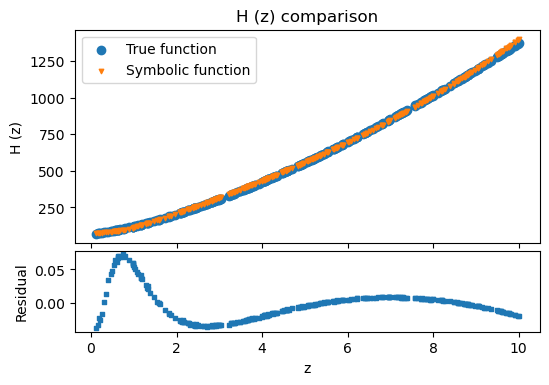

In [23]:
# Plot 
fig = plt.figure(constrained_layout=False, dpi=100)
gs = fig.add_gridspec(nrows=7, ncols=1)
f_ax1 = fig.add_subplot(gs[0:5,0])
plt.title('H (z) comparison')
plt.scatter(X_test, y_test, label = 'True function')
plt.scatter(X_test, y_gp2, marker = 'v', s = 10, label = 'Symbolic function')
plt.legend()
plt.ylabel('H (z)')
f_ax2 = fig.add_subplot(gs[5:7, 0])
plt.scatter(X_test, 1. - y_gp2/y_test, marker = 's', s = 10)
plt.ylabel('Residual')
plt.xlabel('z')

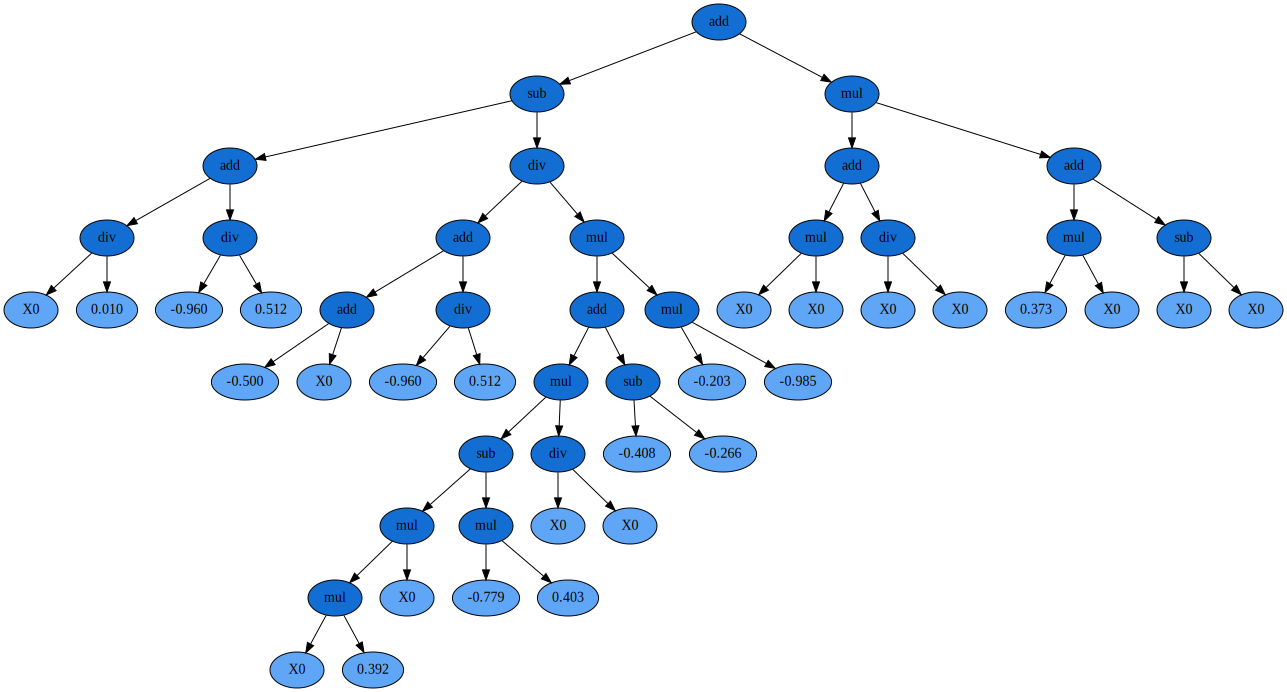

In [24]:
# Tree 
dot_data = est_gp._program.export_graphviz()
graph = graphviz.Source(dot_data)
graph.render('images/ex2', format='png', cleanup=True)
graph

## 4.5 Comparing GPlearn to traditional ML approaches

### 4.5.1 Decision Tree Regressor

In [25]:
# Model and Fit 
est_tree = DecisionTreeRegressor(max_depth=5)
t0 = time.time()
est_tree.fit(X_train, y_train)
print('Time to fit:', time.time() - t0, 'seconds')

Time to fit: 0.004052162170410156 seconds


In [26]:
# Prediction and score 
t0 = time.time()
y_tree = est_tree.predict(X_test)
print('Time to predict:', time.time() - t0, 'seconds')

Time to predict: 0.0020034313201904297 seconds


In [27]:
#Score
score_tree = est_tree.score(X_test, y_test)
print('DT:', score_tree)

DT: 0.9988349515076335


Text(0.5, 0, 'z')

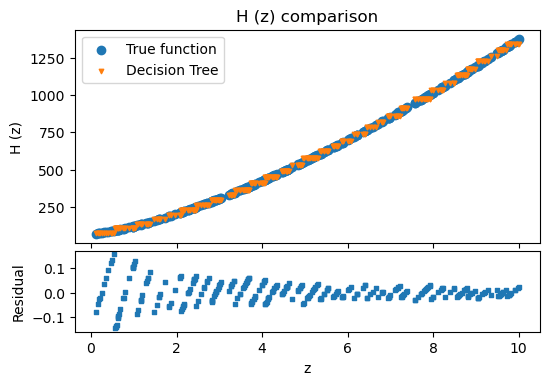

In [28]:
# Plot 
fig = plt.figure(constrained_layout=False, dpi=100)
gs = fig.add_gridspec(nrows=7, ncols=1)
f_ax1 = fig.add_subplot(gs[0:5,0])
plt.title('H (z) comparison')
plt.scatter(X_test, y_test, label = 'True function')
plt.scatter(X_test, y_tree, marker = 'v', s = 10, label = 'Decision Tree')
plt.legend()
plt.ylabel('H (z)')
f_ax2 = fig.add_subplot(gs[5:7, 0])
plt.scatter(X_test, 1. - y_tree/y_test, marker = 's', s = 10)
plt.ylabel('Residual')
plt.xlabel('z')

### 4.5.2 Random Forest Regressor

In [29]:
# Model and Fit 
est_rf = RandomForestRegressor(n_estimators=100,max_depth=5)
t0 = time.time()
est_rf.fit(X_train, y_train)
print('Time to fit:', time.time() - t0, 'seconds')

Time to fit: 0.11200666427612305 seconds


In [30]:
# Prediction and Score 
t0 = time.time()
y_rf = est_rf.predict(X_test)
print('Time to predict:', time.time() - t0, 'seconds')

Time to predict: 0.010998964309692383 seconds


In [31]:
score_rf = est_rf.score(X_test, y_test)
print('RF:', score_rf)

RF: 0.999856938528358


Text(0.5, 0, 'z')

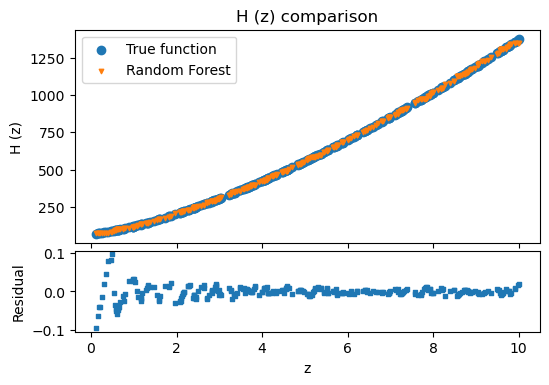

In [32]:
#Plot
fig = plt.figure(constrained_layout=False, dpi=100)
gs = fig.add_gridspec(nrows=7, ncols=1)
f_ax1 = fig.add_subplot(gs[0:5,0])
plt.title('H (z) comparison')
plt.scatter(X_test, y_test, label = 'True function')
plt.scatter(X_test, y_rf, marker = 'v', s = 10, label = 'Random Forest')
plt.legend()
plt.ylabel('H (z)')
f_ax2 = fig.add_subplot(gs[5:7, 0])
plt.scatter(X_test, 1. - y_rf/y_test, marker = 's', s = 10)
plt.ylabel('Residual')
plt.xlabel('z')

### 4.5.3 All together

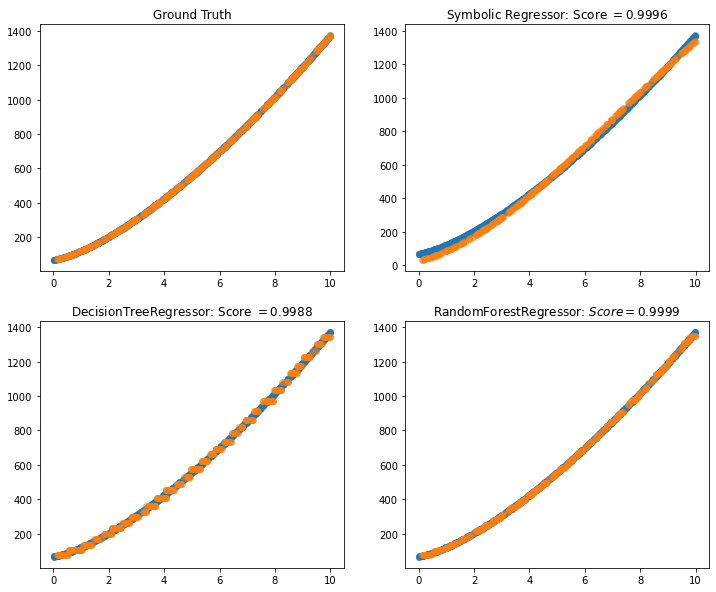

In [33]:
fig = plt.figure(figsize=(12, 10))
for i, (y, score, title) in enumerate([(y_test, None, "Ground Truth"),
                                       (y_gp, score_gp2, r"Symbolic Regressor: Score $= {:.4f}$".format(score_gp2)),
                                       (y_tree, score_tree, r"DecisionTreeRegressor: Score $= {:.4f}$".format(score_tree)),
                                       (y_rf, score_rf, r"RandomForestRegressor: $Score = {:.4f}$".format(score_rf))]):
    ax = fig.add_subplot(2, 2, i+1)
    points = ax.scatter(X, y_true, alpha=0.5)
    test = ax.scatter(X_test,y, alpha=0.5)
    plt.title(title)

## 5. Symbolic Classifier

### 5.1 Importing libraries

In [34]:
from gplearn.genetic import SymbolicClassifier
from sklearn.datasets import load_boston
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

### 5.2 Wisconsin breast cancer

In [35]:
from sklearn.datasets import load_breast_cancer
cancer = load_breast_cancer()

In [36]:
# Description
print(cancer.DESCR)

.. _breast_cancer_dataset:

Breast cancer wisconsin (diagnostic) dataset
--------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 569

    :Number of Attributes: 30 numeric, predictive attributes and the class

    :Attribute Information:
        - radius (mean of distances from center to points on the perimeter)
        - texture (standard deviation of gray-scale values)
        - perimeter
        - area
        - smoothness (local variation in radius lengths)
        - compactness (perimeter^2 / area - 1.0)
        - concavity (severity of concave portions of the contour)
        - concave points (number of concave portions of the contour)
        - symmetry
        - fractal dimension ("coastline approximation" - 1)

        The mean, standard error, and "worst" or largest (mean of the three
        worst/largest values) of these features were computed for each image,
        resulting in 30 features.  For instance, field 0 is Mean Radi

### 5.3 Data Preprocessing

#### 5.5.1 Shuffling data

In [37]:
rng = check_random_state(0)
perm = rng.permutation(cancer.target.size)
cancer.data = cancer.data[perm]
cancer.target = cancer.target[perm]

#### 5.5.2 Spliting data

In [38]:
X_train = cancer.data[:400]
y_train = cancer.target[:400]
X_test = cancer.data[400:]
y_test = cancer.target[400:]
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((400, 30), (400,), (169, 30), (169,))

### 5.3 Classifying

In [39]:
est = SymbolicClassifier(parsimony_coefficient=.01,
                         feature_names=cancer.feature_names,
                         random_state=1)

#### 5.3.1 Fit

In [40]:
t0 = time.time()
est.fit(X_train, y_train)
print('Time to fit:', time.time() - t0, 'seconds')

Time to fit: 10.336442947387695 seconds


#### 5.3.2 Predicting

In [41]:
y_gpclas = est.predict_proba(X_test)[:,1]
y_gpclas.shape

(169,)

#### 5.3.3 Scoring

In [42]:
score = roc_auc_score(y_test, y_gpclas)
score

0.9693786982248521

## 5.4 Visualizing 

In [43]:
# ROC Curve
cutoff = 0.7
y_test_classes = np.zeros_like(y_test)
y_test_classes[y_test > cutoff] = 1

cutoff = 0.7
y_gpclas_classes = np.zeros_like(y_gpclas)
y_gpclas_classes[y_gpclas > cutoff] = 1

In [44]:
fpr, tpr, thresholds = roc_curve(y_test_classes, y_gpclas_classes)

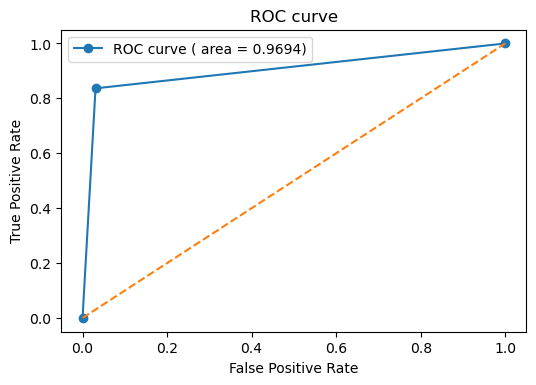

In [45]:
plt.figure(dpi=100)
plt.plot(fpr, tpr, '-o', label = r'ROC curve ( area = {:.4})'.format(score))
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend()

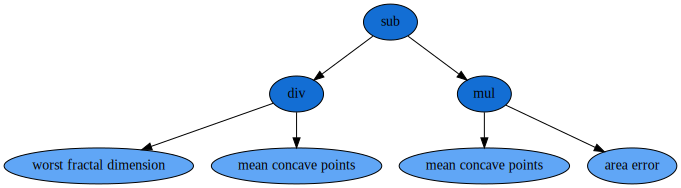

In [46]:
# Tree 

dot_data = est._program.export_graphviz()
graph = graphviz.Source(dot_data)
graph